<a href="https://colab.research.google.com/github/Sumit-Nayek/ML_Projects/blob/main/Cross_validation_of_RTPCR_screeing_and_stratification_22_05_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# standard imports and setup
from scipy import stats
# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import *
# pipelines
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
# data preparation
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import resample
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE
# machine learning
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score,classification_report,roc_auc_score,roc_curve,precision_score,recall_score,accuracy_score


In [ ]:
only_sympoms_filtered_data=pd.read_csv('/content/symptoms_data_with_all_the_ct_values.csv')
## Balancing the r=target variable for unbaised model performance
### Problem of biased target variable
#Define the independent and dependent variables
df=only_sympoms_filtered_data.loc[:, only_sympoms_filtered_data.columns != 'generated_result']
df=df.loc[:, df.columns != 'final_test_result']
y=only_sympoms_filtered_data['generated_result']
# model_data.info()
t=pd.get_dummies(df)
# t.info()
x= t
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
# print(scaled_data)
# splitting the data
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2,random_state=12)
# ############################################################ Data Balancing
# # numerical features
# num_cols = ['age']

# # apply standardization on numerical features
# for i in num_cols:

#     # fit on training data column
#     scale = MinMaxScaler().fit(x_train[[i]])

#     # transform the training data column
#     x_train[i] = scale.transform(x_train[[i]])

#     # transform the testing data column
#     x_test[i] = scale.transform(x_test[[i]])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25634 entries, 0 to 25633
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           25634 non-null  int64  
 1   underlying_medical_condition  25634 non-null  int64  
 2   ct_value_screening            25634 non-null  float64
 3   ct_value_rdrp                 25634 non-null  float64
 4   ct_value_orf1b                25634 non-null  float64
 5   fever                         25634 non-null  int64  
 6   cough                         25634 non-null  int64  
 7   breathlessness                25634 non-null  int64  
 8   body_ache                     25634 non-null  int64  
 9   vomiting                      25634 non-null  int64  
 10  sore_throat                   25634 non-null  int64  
 11  diarrhoea                     25634 non-null  int64  
 12  sputum                        25634 non-null  int64  
 13  n

In [ ]:
### Outlier treatment
percentile25 = df['ct_value_rdrp'].quantile(0.25)
percentile75 = df['ct_value_rdrp'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
df[df['ct_value_rdrp'] > upper_limit]
df[df['ct_value_rdrp'] < lower_limit]
new_df = df[df['ct_value_rdrp'] < upper_limit]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25352 entries, 0 to 25633
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           25352 non-null  int64  
 1   underlying_medical_condition  25352 non-null  int64  
 2   ct_value_screening            25352 non-null  float64
 3   ct_value_rdrp                 25352 non-null  float64
 4   ct_value_orf1b                25352 non-null  float64
 5   fever                         25352 non-null  int64  
 6   cough                         25352 non-null  int64  
 7   breathlessness                25352 non-null  int64  
 8   body_ache                     25352 non-null  int64  
 9   vomiting                      25352 non-null  int64  
 10  sore_throat                   25352 non-null  int64  
 11  diarrhoea                     25352 non-null  int64  
 12  sputum                        25352 non-null  int64  
 13  nausea

In [ ]:
df = df.drop(columns=['ct_value_rdrp', 'ct_value_orf1b'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25634 entries, 0 to 25633
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           25634 non-null  int64  
 1   underlying_medical_condition  25634 non-null  int64  
 2   ct_value_screening            25634 non-null  float64
 3   fever                         25634 non-null  int64  
 4   cough                         25634 non-null  int64  
 5   breathlessness                25634 non-null  int64  
 6   body_ache                     25634 non-null  int64  
 7   vomiting                      25634 non-null  int64  
 8   sore_throat                   25634 non-null  int64  
 9   diarrhoea                     25634 non-null  int64  
 10  sputum                        25634 non-null  int64  
 11  nausea                        25634 non-null  int64  
 12  nasal_discharge               25634 non-null  int64  
 13  l

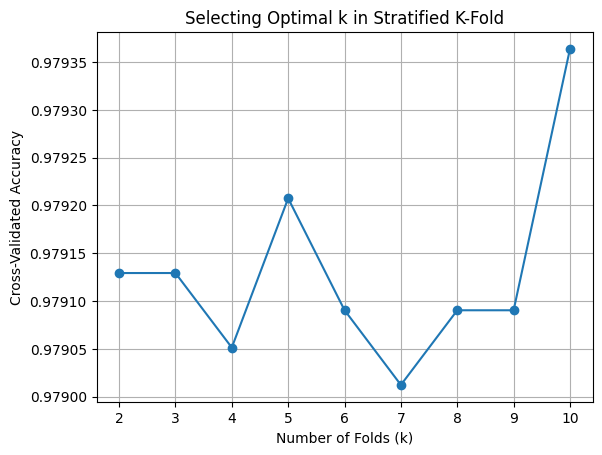

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
model = LogisticRegression(max_iter=2)
k_values = list(range(2, 11))
scores = []

for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    score = cross_val_score(model, x, y, cv=skf, scoring='accuracy')
    scores.append(score.mean())

plt.plot(k_values, scores, marker='o')
plt.xlabel("Number of Folds (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Selecting Optimal k in Stratified K-Fold")
plt.grid(True)
plt.show()


In [ ]:
# Define models
models= {
    'SVM (linear)': SVC(kernel='linear'),
    # 'SVM (rbf)': SVC(kernel='rbf'),
    # 'SVM (poly)': SVC(kernel='poly'),
    # 'SVM (sigmoid)': SVC(kernel='sigmoid'),
    # 'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression()
}

# Evaluate models using k-fold cross-validation
k = 3  # use the best k found previously
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, x, y, cv=kf)
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std Dev = {scores.std():.4f}")

    # Fit the model and make predictions on the test set (optional)
    model.fit(x, y)
    y_pred = model.predict(x)
    accuracy = accuracy_score(y, y_pred)
    print(f"{name}: Test Accuracy = {accuracy:.4f}")


SVM (linear): Mean Accuracy = 0.9948, Std Dev = 0.0006
SVM (linear): Test Accuracy = 0.9948
Decision Tree: Mean Accuracy = 1.0000, Std Dev = 0.0000
Decision Tree: Test Accuracy = 1.0000
Logistic Regression: Mean Accuracy = 0.9948, Std Dev = 0.0005
Logistic Regression: Test Accuracy = 0.9949


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

model = LogisticRegression(max_iter=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Store scores
accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # ✅ Apply SMOTE only on training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

    # Train
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_val)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Store
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f}")
# Print Mean Scores
print("\n=== Mean Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")


Fold 1 | Acc: 0.9836 | F1: 0.9917 | Sensitivity: 0.9891 | Specificity: 0.6282
Fold 2 | Acc: 0.9941 | F1: 0.9970 | Sensitivity: 0.9992 | Specificity: 0.6667
Fold 3 | Acc: 0.9723 | F1: 0.9858 | Sensitivity: 0.9778 | Specificity: 0.6203
Fold 4 | Acc: 0.9836 | F1: 0.9917 | Sensitivity: 0.9891 | Specificity: 0.6329
Fold 5 | Acc: 0.9926 | F1: 0.9962 | Sensitivity: 0.9962 | Specificity: 0.7564

=== Mean Metrics Across Folds ===
Mean Accuracy: 0.9853
Mean F1 Score: 0.9925
Mean Sensitivity: 0.9903
Mean Specificity: 0.6609


In [ ]:
### Decision Tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Store scores
accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # ✅ Apply SMOTE only on training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

    # Train
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_val)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Store
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f}")
# Print Mean Scores
print("\n=== Mean Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")

Fold 1 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000
Fold 2 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000
Fold 3 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000
Fold 4 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000
Fold 5 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000

=== Mean Metrics Across Folds ===
Mean Accuracy: 1.0000
Mean F1 Score: 1.0000
Mean Sensitivity: 1.0000
Mean Specificity: 1.0000


In [ ]:
### Random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Store scores
accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # ✅ Apply SMOTE only on training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

    # Train
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_val)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Store
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f}")
# Print Mean Scores
print("\n=== Mean Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")

Fold 1 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000
Fold 2 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000
Fold 3 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000
Fold 4 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000
Fold 5 | Acc: 1.0000 | F1: 1.0000 | Sensitivity: 1.0000 | Specificity: 1.0000

=== Mean Metrics Across Folds ===
Mean Accuracy: 1.0000
Mean F1 Score: 1.0000
Mean Sensitivity: 1.0000
Mean Specificity: 1.0000


In [ ]:
### Support Vector Machine
from sklearn.svm import SVC
model = SVC()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Store scores
accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # ✅ Apply SMOTE only on training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

    # Train
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_val)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Store
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f}")
# Print Mean Scores
print("\n=== Mean Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")

Fold 1 | Acc: 0.9889 | F1: 0.9944 | Sensitivity: 0.9950 | Specificity: 0.5897
Fold 2 | Acc: 0.9938 | F1: 0.9968 | Sensitivity: 0.9998 | Specificity: 0.6026
Fold 3 | Acc: 0.9873 | F1: 0.9936 | Sensitivity: 0.9919 | Specificity: 0.6962
Fold 4 | Acc: 0.9912 | F1: 0.9956 | Sensitivity: 0.9974 | Specificity: 0.5949
Fold 5 | Acc: 0.9897 | F1: 0.9947 | Sensitivity: 0.9933 | Specificity: 0.7564

=== Mean Metrics Across Folds ===
Mean Accuracy: 0.9902
Mean F1 Score: 0.9950
Mean Sensitivity: 0.9955
Mean Specificity: 0.6480


In [ ]:
### Support Vector Machine (RBF kernel)
from sklearn.svm import SVC
model = SVC(kernel='rbf')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Store scores
accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # ✅ Apply SMOTE only on training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

    # Train
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_val)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Store
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f}")
# Print Mean Scores
print("\n=== Mean Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")

Fold 1 | Acc: 0.9889 | F1: 0.9944 | Sensitivity: 0.9950 | Specificity: 0.5897
Fold 2 | Acc: 0.9938 | F1: 0.9968 | Sensitivity: 0.9998 | Specificity: 0.6026
Fold 3 | Acc: 0.9873 | F1: 0.9936 | Sensitivity: 0.9919 | Specificity: 0.6962
Fold 4 | Acc: 0.9912 | F1: 0.9956 | Sensitivity: 0.9974 | Specificity: 0.5949
Fold 5 | Acc: 0.9897 | F1: 0.9947 | Sensitivity: 0.9933 | Specificity: 0.7564

=== Mean Metrics Across Folds ===
Mean Accuracy: 0.9902
Mean F1 Score: 0.9950
Mean Sensitivity: 0.9955
Mean Specificity: 0.6480


In [ ]:
### Support Vector Machine (RBF kernel)
from sklearn.svm import SVC
model = SVC(kernel='sigmoid')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Store scores
accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # ✅ Apply SMOTE only on training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

    # Train
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_val)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Store
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f}")
# Print Mean Scores
print("\n=== Mean Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")

Fold 1 | Acc: 0.9875 | F1: 0.9937 | Sensitivity: 0.9931 | Specificity: 0.6282
Fold 2 | Acc: 0.9887 | F1: 0.9943 | Sensitivity: 0.9937 | Specificity: 0.6667
Fold 3 | Acc: 0.9932 | F1: 0.9965 | Sensitivity: 0.9976 | Specificity: 0.7089
Fold 4 | Acc: 0.9883 | F1: 0.9941 | Sensitivity: 0.9941 | Specificity: 0.6203
Fold 5 | Acc: 0.9897 | F1: 0.9947 | Sensitivity: 0.9933 | Specificity: 0.7564

=== Mean Metrics Across Folds ===
Mean Accuracy: 0.9895
Mean F1 Score: 0.9946
Mean Sensitivity: 0.9943
Mean Specificity: 0.6761


In [ ]:
### Naive bayes classfication
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Store scores
# Store scores
accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # ✅ Apply SMOTE only on training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

    # Train
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_val)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Store
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f}")
# Print Mean Scores
print("\n=== Mean Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")

Fold 1 | Acc: 0.0884 | F1: 0.1386 | Sensitivity: 0.0745 | Specificity: 0.9872
Fold 2 | Acc: 0.0878 | F1: 0.1372 | Sensitivity: 0.0737 | Specificity: 1.0000
Fold 3 | Acc: 0.0653 | F1: 0.0972 | Sensitivity: 0.0511 | Specificity: 0.9747
Fold 4 | Acc: 0.0610 | F1: 0.0889 | Sensitivity: 0.0466 | Specificity: 0.9873
Fold 5 | Acc: 0.0468 | F1: 0.0625 | Sensitivity: 0.0323 | Specificity: 0.9872

=== Mean Metrics Across Folds ===
Mean Accuracy: 0.0699
Mean F1 Score: 0.1049
Mean Sensitivity: 0.0556
Mean Specificity: 0.9873


In [ ]:
## ANN with 2 hidden layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(x.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Output layer with softmax for multi-class
])
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Store scores
accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []

# Convert y to one-hot encoded format
y_onehot = to_categorical(y, num_classes=3)
# Change your model compilation to:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Then in your training loop, use y_onehot instead of y:
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y_onehot[train_idx], y_onehot[val_idx]

    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # ✅ Apply SMOTE only on training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

    # Train
    model.fit(x_train_res, y_train_res)
    y_pred_probs = model.predict(x_val)  # Raw probabilities (shape: [n_samples, 3])
    y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class indices (0, 1, 2)

    # If y_val is one-hot encoded, convert it back to class indices:
    y_val_classes = np.argmax(y_val, axis=1)
    # Now compute metrics:
    acc = accuracy_score(y_val_classes, y_pred_classes)
    f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')  # For multi-class
    recall = recall_score(y_val_classes, y_pred_classes, average='weighted')
    tn, fp, fn, tp = confusion_matrix(y_val_classes, y_pred_classes).ravel()
    specificity = tn / (tn + fp)

    # Store
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f}")
# Print Mean Scores
print("\n=== Mean Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8327 - loss: 0.3654
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 1 | Acc: 0.9746 | F1: 0.9791 | Sensitivity: 0.9746 | Specificity: 0.7308
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9655 - loss: 0.1180
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 | Acc: 0.9805 | F1: 0.9839 | Sensitivity: 0.9805 | Specificity: 0.9231
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9869 - loss: 0.0504
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 | Acc: 0.9826 | F1: 0.9854 | Sensitivity: 0.9826 | Specificity: 0.9114
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9912 - loss: 0.0339
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 | Acc: 0.9908 | F1: 0.9916 | Sensitivity: 0.9908 | Specificity: 0.8987
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9907 - loss: 0.0308
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 5 | Acc: 0.9949 | F1: 0.9953 | Sensitivity: 0.9949 | Specificity: 0.9872

=== Mean Metrics Ac

### For Rsik stratification task

In [ ]:
only_sympoms_filtered_data=pd.read_csv('/content/symptoms_data_with_all_the_ct_values.csv')
## Balancing the r=target variable for unbaised model performance
### Problem of biased target variable
#Define the independent and dependent variables
df1=only_sympoms_filtered_data.loc[:, only_sympoms_filtered_data.columns != 'generated_result']
df1=df1.loc[:, df1.columns != 'final_test_result']
y1=only_sympoms_filtered_data['generated_result']
# # model_data.info()
# t1=pd.get_dummies(df1)
# # t.info()
# x1= t1
bins=[0, 20, 30,200]
bins
labels=['High_risk', 'Modarate_risk', 'Low_risk']
df1['Risk_lebel'] = pd.cut(df1['ct_value_rdrp'], bins, labels=labels)
df1.info()
# from sklearn.preprocessing import MinMaxScaler
# # print(scaled_data)
# # splitting the data
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2,random_state=12)
# ############################################################ Data Balancing
# # numerical features
# num_cols = ['age']

# # apply standardization on numerical features
# for i in num_cols:

#     # fit on training data column
#     scale = MinMaxScaler().fit(x_train[[i]])

#     # transform the training data column
#     x_train[i] = scale.transform(x_train[[i]])

#     # transform the testing data column
#     x_test[i] = scale.transform(x_test[[i]])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25634 entries, 0 to 25633
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   age                           25634 non-null  int64   
 1   underlying_medical_condition  25634 non-null  int64   
 2   ct_value_screening            25634 non-null  float64 
 3   ct_value_rdrp                 25634 non-null  float64 
 4   ct_value_orf1b                25634 non-null  float64 
 5   fever                         25634 non-null  int64   
 6   cough                         25634 non-null  int64   
 7   breathlessness                25634 non-null  int64   
 8   body_ache                     25634 non-null  int64   
 9   vomiting                      25634 non-null  int64   
 10  sore_throat                   25634 non-null  int64   
 11  diarrhoea                     25634 non-null  int64   
 12  sputum                        25634 non-null  

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

# Handle missing/non-standard values
labels = ['High_risk', 'Modarate_risk', 'Low_risk']
df1['Risk_lebel'] = df1['Risk_lebel'].str.strip()  # Remove whitespace

# 2. Safe encoding with validation
def safe_encode(x):
    try:
        return labels.index(x)
    except ValueError:
        return -1  # Will be filtered later

df1['Encoded'] = df1['Risk_lebel'].apply(safe_encode)

# Check for invalid encodings
invalid = df1[df1['Encoded'] == -1]
if not invalid.empty:
    print("Warning: Found invalid labels:")
    print(invalid['Risk_lebel'].unique())
    df1 = df1[df1['Encoded'] != -1]  # Remove invalid rows

# 3. Verify encoded values
y = df1['Encoded']
print("Valid encoded values:", y.unique())
assert y.min() >= 0 and y.max() < 3, "Encoded values must be 0, 1, or 2"

# 4. Convert to categorical
y_onehot = to_categorical(y, num_classes=3)
print("Categorical shape:", y_onehot.shape)

# 5. Drop columns
columns_to_drop = [
    'generated_result','final_test_result', 'ct_value_rdrp', 'ct_value_orf1b', 'Risk_lebel'
]
df1 = df1.drop(columns=[col for col in columns_to_drop if col in df1.columns])

[nan]
Valid encoded values: [1 2 0]
Categorical shape: (25369, 3)


In [ ]:
df1.Encoded.value_counts()

,count
Encoded,
1,14743
0,6051
2,4575


In [ ]:
df1.columns

Index(['age', 'underlying_medical_condition', 'ct_value_screening', 'fever',
       'cough', 'breathlessness', 'body_ache', 'vomiting', 'sore_throat',
       'diarrhoea', 'sputum', 'nausea', 'nasal_discharge', 'loss_of_taste',
       'loss_of_smell', 'abdominal_pain', 'chest_pain', 'haemoptsis',
       'head_ache', 'body_pain', 'weak_ness', 'cold', 'Encoded'],
      dtype='object')

In [ ]:
t1=df1.loc[:, df1.columns != 'Encoded']
x1=t1
y1=df1['Encoded']

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import numpy as np

# Function to calculate multi-class specificity
def multiclass_specificity(y_true, y_pred, n_classes):
    cm = confusion_matrix(y_true, y_pred)
    specificities = []
    for i in range(n_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        specificities.append(specificity)
    return np.mean(specificities)  # Return average specificity

# Define models to evaluate
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model and evaluate
for name, model in classification_models.items():
    print(f"\n--- Evaluating {name} ---")

    accuracies = []
    f1_scores = []
    sensitivities = []  # recall for positive class (weighted average)
    specificities = []
    precisions = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(x1, y1)):
        x_train, x_val = x1.iloc[train_idx], x1.iloc[val_idx]
        y_train, y_val = y1.iloc[train_idx], y1.iloc[val_idx]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_val_scaled = scaler.transform(x_val)

        # Apply SMOTE only on the training data
        sm = SMOTE(random_state=42)
        x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

        # Train the model
        model.fit(x_train_res, y_train_res)

        # Predict on the validation set
        y_pred = model.predict(x_val_scaled)

        # Calculate all metrics for multi-class
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        recall = recall_score(y_val, y_pred, average='weighted')  # Sensitivity (weighted)
        precision = precision_score(y_val, y_pred, average='weighted')
        specificity = multiclass_specificity(y_val, y_pred, n_classes=3)

        # Store metrics for this fold
        accuracies.append(acc)
        f1_scores.append(f1)
        sensitivities.append(recall)
        specificities.append(specificity)
        precisions.append(precision)

        print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity: {recall:.4f} | Specificity: {specificity:.4f} | Precision: {precision:.4f}")

    # Print Mean Scores across all folds for the current model
    print(f"\n=== Mean Metrics Across Folds for {name} ===")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Mean Sensitivity: {np.mean(sensitivities):.4f}")
    print(f"Mean Specificity: {np.mean(specificities):.4f}")
    print(f"Mean Precision: {np.mean(precisions):.4f}")


--- Evaluating Logistic Regression ---
Fold 1 | Acc: 0.7266 | F1: 0.7294 | Sensitivity: 0.7266 | Specificity: 0.8634 | Precision: 0.7664
Fold 2 | Acc: 0.7345 | F1: 0.7370 | Sensitivity: 0.7345 | Specificity: 0.8670 | Precision: 0.7714
Fold 3 | Acc: 0.7371 | F1: 0.7395 | Sensitivity: 0.7371 | Specificity: 0.8690 | Precision: 0.7747
Fold 4 | Acc: 0.7284 | F1: 0.7311 | Sensitivity: 0.7284 | Specificity: 0.8637 | Precision: 0.7671
Fold 5 | Acc: 0.7225 | F1: 0.7253 | Sensitivity: 0.7225 | Specificity: 0.8610 | Precision: 0.7621

=== Mean Metrics Across Folds for Logistic Regression ===
Mean Accuracy: 0.7298
Mean F1 Score: 0.7325
Mean Sensitivity: 0.7298
Mean Specificity: 0.8648
Mean Precision: 0.7683

--- Evaluating Decision Tree ---
Fold 1 | Acc: 0.7085 | F1: 0.7079 | Sensitivity: 0.7085 | Specificity: 0.8263 | Precision: 0.7084
Fold 2 | Acc: 0.7093 | F1: 0.7079 | Sensitivity: 0.7093 | Specificity: 0.8234 | Precision: 0.7073
Fold 3 | Acc: 0.7134 | F1: 0.7122 | Sensitivity: 0.7134 | Specif

In [ ]:
# # prompt: Draw roc curve for all these models

# import numpy as np
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import StratifiedKFold
# import matplotlib.pyplot as plt

# # Define models for ROC curve analysis (must support predict_proba)
# # ANN is handled separately as it's a Keras model
# roc_models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs'), # 'ovr' for predict_proba
#     'Decision Tree': DecisionTreeClassifier(random_state=42),
#     'Random Forest': RandomForestClassifier(random_state=42),
#     'K-Nearest Neighbors': KNeighborsClassifier(),
#     'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # use_label_encoder=False
# }

# # Stratified K-Fold for consistent splits
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# plt.figure(figsize=(10, 8))

# # Loop through each model for ROC
# for name, model in roc_models.items():
#     print(f"\n--- Generating ROC for {name} ---")

#     # Aggregated false positive rate and true positive rate over folds
#     tprs = []
#     aucs = []
#     mean_fpr = np.linspace(0, 1, 100)

#     for fold, (train_idx, val_idx) in enumerate(skf.split(x1, y1)):
#         x_train, x_val = x1.iloc[train_idx], x1.iloc[val_idx]
#         y_train, y_val = y1.iloc[train_idx], y1.iloc[val_idx]

#         # Standardize features
#         scaler = StandardScaler()
#         x_train_scaled = scaler.fit_transform(x_train)
#         x_val_scaled = scaler.transform(x_val)

#         # Apply SMOTE only on the training data
#         sm = SMOTE(random_state=42)
#         x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

#         # Train the model
#         model.fit(x_train_res, y_train_res)

#         # Get probabilities for the positive class (assuming binary or one vs rest)
#         # For multi-class, we'll plot ROC for each class against the rest.
#         # Here, let's simplify and plot for a single class vs rest or
#         # average across classes using OvR strategy. Logistic Regression with OvR supports this.
#         # For models that don't directly support multi-class ROC with predict_proba easily,
#         # we might need to train OvR classifiers or use a different strategy.
#         # Let's assume a simplified scenario or use predict_proba for all classes and
#         # plot one curve (e.g., for class 1 vs rest or a micro/macro average if needed).
#         # For clarity and common usage, let's plot the ROC for each class in multi-class case.

#         if hasattr(model, "predict_proba"):
#              # Calculate ROC curve and AUC for each class against the rest
#             y_val_onehot = to_categorical(y_val, num_classes=3)
#             y_proba = model.predict_proba(x_val_scaled)

#             for i in range(3): # Loop through each class
#                 fpr, tpr, thresholds = roc_curve(y_val_onehot[:, i], y_proba[:, i])
#                 tprs.append(np.interp(mean_fpr, fpr, tpr)) # Interpolate to the common FPR
#                 tprs[-1][0] = 0.0 # Ensure the start is at (0,0)
#                 roc_auc = auc(fpr, tpr)
#                 aucs.append(roc_auc)
#                 # print(f"Fold {fold+1} | Class {i}: AUC = {roc_auc:.4f}")

#         elif name == 'Support Vector Machine' and hasattr(model, "decision_function"):
#              # For SVC without probability calibration, use decision_function
#             y_score = model.decision_function(x_val_scaled)
#             # Assuming binary or OvR decision function
#             # For multi-class SVC, decision_function returns shape (n_samples, n_classes * (n_classes - 1) / 2)
#             # Plotting ROC for this requires OvR strategy or similar.
#             # Let's stick to models with predict_proba for easier multi-class ROC plotting.
#             print(f"Skipping ROC for {name} as predict_proba is not directly available without calibration.")
#             continue

#         else:
#              print(f"Skipping ROC for {name} as it does not have predict_proba.")
#              continue


#     if len(tprs) > 0:
#         mean_tpr = np.mean(tprs, axis=0)
#         mean_tpr[-1] = 1.0 # Ensure the end is at (1,1)
#         mean_auc = auc(mean_fpr, mean_tpr)
#         std_auc = np.std(aucs)

#         plt.plot(mean_fpr, mean_tpr,
#                  label=f'{name} (Mean AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
#                  lw=2, alpha=.8)

#         # std_tpr = np.std(tprs, axis=0)
#         # tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#         # tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#         # plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#         #                  label=r'$\pm$ 1 std. dev.')

# # Handle ANN separately for ROC
# # Need to train and predict probabilities with the Keras model
# print("\n--- Generating ROC for ANN ---")

# ann_tprs = []
# ann_aucs = []
# ann_mean_fpr = np.linspace(0, 1, 100)

# # Re-initialize the ANN model
# model_ann = Sequential([
#     Dense(64, activation='relu', input_shape=(x1.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(3, activation='softmax')
# ])
# model_ann.compile(optimizer=Adam(),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

# # Convert y1 to one-hot for training the ANN
# y1_onehot_ann = to_categorical(y1, num_classes=3)

# for fold, (train_idx, val_idx) in enumerate(skf.split(x1, y1)):
#     x_train, x_val = x1.iloc[train_idx], x1.iloc[val_idx]
#     y_train, y_val = y1.iloc[train_idx], y1.iloc[val_idx] # Keep original y_val for metric calculation
#     y_train_onehot_ann = y1_onehot_ann[train_idx]
#     y_val_onehot_ann = y1_onehot_ann[val_idx]

#     # Standardize features
#     scaler = StandardScaler()
#     x_train_scaled = scaler.fit_transform(x_train)
#     x_val_scaled = scaler.transform(x_val)

#     # Apply SMOTE only on the training data (Need to handle SMOTE with one-hot if needed,
#     # but for plotting ROC with predict_proba, SMOTE on features and original labels might be easier
#     # or apply SMOTE before one-hot encoding y_train). Let's resample x and original y, then one-hot.
#     sm = SMOTE(random_state=42)
#     x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)
#     y_train_res_onehot_ann = to_categorical(y_train_res, num_classes=3)


#     # Train the ANN model (use resampled and one-hot encoded data)
#     # Fit with one epoch to avoid excessive training time just for plotting
#     model_ann.fit(x_train_res, y_train_res_onehot_ann, epochs=1, verbose=0)

#     # Get probabilities
#     y_proba_ann = model_ann.predict(x_val_scaled)

#     # Calculate ROC for each class against the rest
#     fold_aucs = []
#     fold_tprs_interp = []
#     for i in range(3): # Loop through each class
#          fpr, tpr, thresholds = roc_curve(y_val_onehot_ann[:, i], y_proba_ann[:, i])
#          fold_tprs_interp.append(np.interp(ann_mean_fpr, fpr, tpr))
#          fold_tprs_interp[-1][0] = 0.0
#          fold_aucs.append(auc(fpr, tpr))

#     # Average the interpolated TPRs and AUCs for this fold across classes
#     ann_tprs.append(np.mean(fold_tprs_interp, axis=0))
#     ann_aucs.append(np.mean(fold_aucs))


# if len(ann_tprs) > 0:
#     ann_mean_tpr = np.mean(ann_tprs, axis=0)
#     ann_mean_tpr[-1] = 1.0
#     ann_mean_auc = auc(ann_mean_fpr, ann_mean_tpr)
#     ann_std_auc = np.std(ann_aucs)

#     plt.plot(ann_mean_fpr, ann_mean_tpr,
#              label=f'ANN (Mean AUC = {ann_mean_auc:.2f} $\pm$ {ann_std_auc:.2f})',
#              lw=2, alpha=.8, linestyle='--')


# plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()


In [ ]:
y1.value_counts()


Evaluating Logistic Regression...

Evaluating Random Forest...

Evaluating XGBoost...

Evaluating K-Nearest Neighbors...

Evaluating ANN...
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


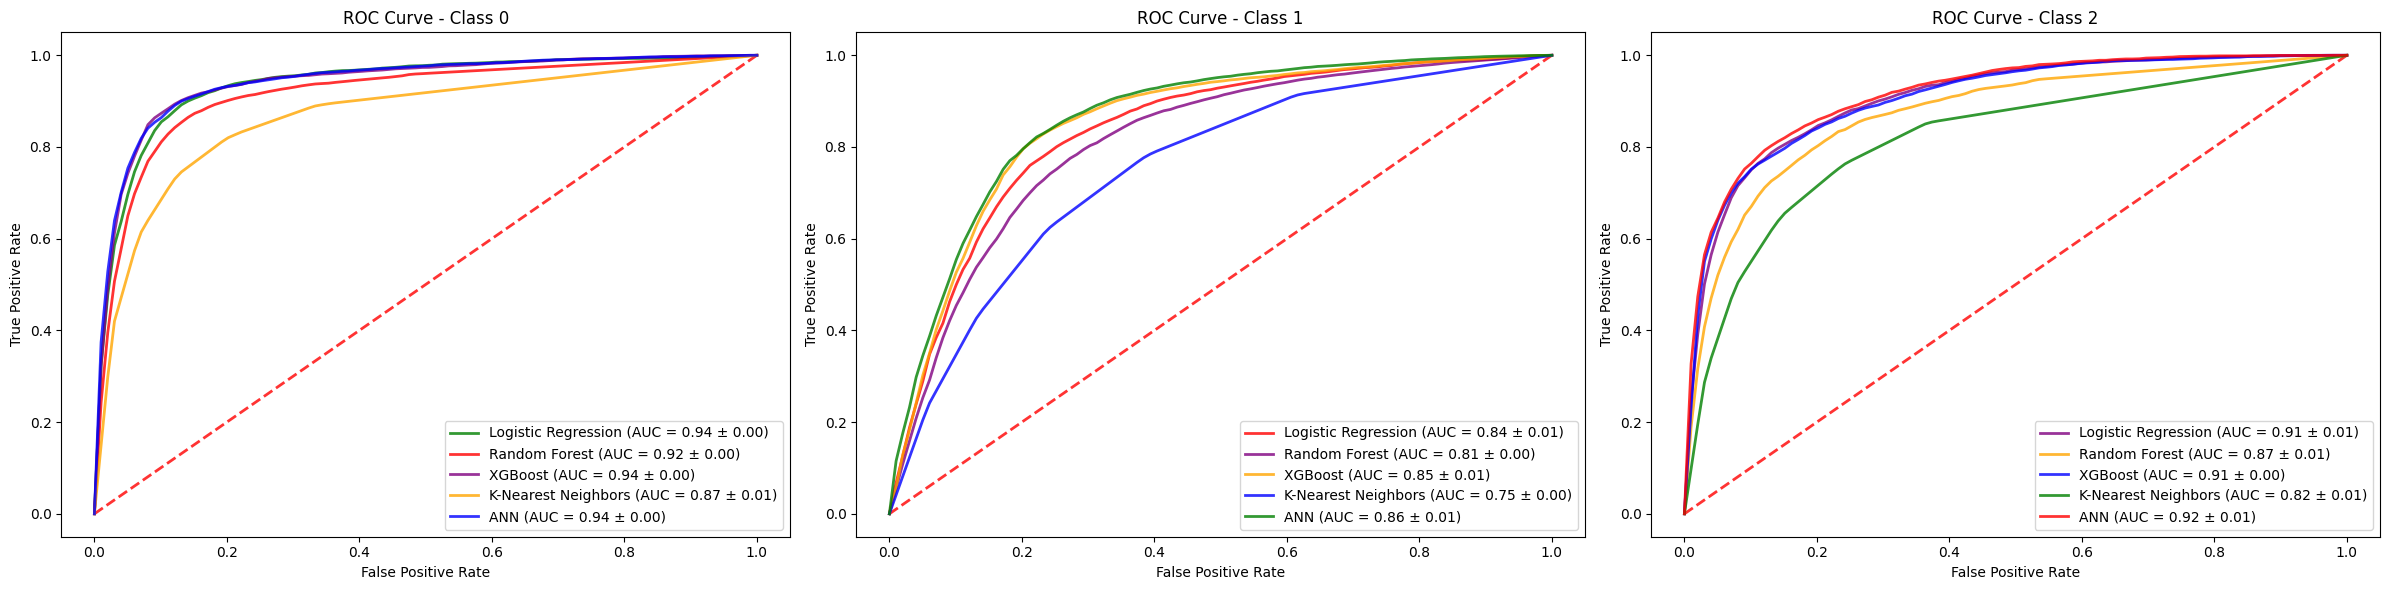

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from itertools import cycle

# Define models for ROC curve analysis
roc_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'ANN': None  # Will handle separately
}

# Binarize the output for multi-class ROC
y1_bin = label_binarize(y1, classes=[0, 1, 2])
n_classes = y1_bin.shape[1]

# Stratified K-Fold for consistent splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a figure with 3 subplots (one for each class)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
class_names = ['Class 0', 'Class 1', 'Class 2']
colors = cycle(['blue', 'green', 'red', 'purple', 'orange'])

# Store results for each model and class
results = {i: {'models': {}} for i in range(n_classes)}

# Evaluate traditional models
for name, model in roc_models.items():
    if name == 'ANN':
        continue

    print(f"\nEvaluating {name}...")

    for class_idx in range(n_classes):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for fold, (train_idx, val_idx) in enumerate(skf.split(x1, y1)):
            x_train, x_val = x1.iloc[train_idx], x1.iloc[val_idx]
            y_train, y_val = y1.iloc[train_idx], y1.iloc[val_idx]
            y_val_bin = y1_bin[val_idx]

            # Standardize features
            scaler = StandardScaler()
            x_train_scaled = scaler.fit_transform(x_train)
            x_val_scaled = scaler.transform(x_val)

            # Apply SMOTE
            sm = SMOTE(random_state=42)
            x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

            # Train and predict
            model.fit(x_train_res, y_train_res)
            y_score = model.predict_proba(x_val_scaled)

            # Compute ROC for this class
            fpr, tpr, _ = roc_curve(y_val_bin[:, class_idx], y_score[:, class_idx])
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

            # Interpolate to common FPR points
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)

        # Store results for this model and class
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        results[class_idx]['models'][name] = {
            'mean_fpr': mean_fpr,
            'mean_tpr': mean_tpr,
            'mean_auc': mean_auc,
            'std_auc': std_auc
        }

# Evaluate ANN separately
print("\nEvaluating ANN...")
model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(x1.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model_ann.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

for class_idx in range(n_classes):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_idx, val_idx) in enumerate(skf.split(x1, y1)):
        x_train, x_val = x1.iloc[train_idx], x1.iloc[val_idx]
        y_train, y_val = y1.iloc[train_idx], y1.iloc[val_idx]
        y_val_bin = y1_bin[val_idx]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_val_scaled = scaler.transform(x_val)

        # Apply SMOTE
        sm = SMOTE(random_state=42)
        x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

        # Train and predict
        model_ann.fit(x_train_res, y_train_res, epochs=10, verbose=0)
        y_score = model_ann.predict(x_val_scaled)

        # Compute ROC for this class
        fpr, tpr, _ = roc_curve(y_val_bin[:, class_idx], y_score[:, class_idx])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Interpolate to common FPR points
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    # Store results for ANN and this class
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    results[class_idx]['models']['ANN'] = {
        'mean_fpr': mean_fpr,
        'mean_tpr': mean_tpr,
        'mean_auc': mean_auc,
        'std_auc': std_auc
    }

# Plot ROC curves for each class in separate subplots
for class_idx in range(n_classes):
    ax = axes[class_idx]
    color = next(colors)

    # Plot chance line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

    # Plot each model's ROC curve
    for model_name, model_data in results[class_idx]['models'].items():
        color = next(colors)
        ax.plot(model_data['mean_fpr'], model_data['mean_tpr'], color=color,
                 label=f'{model_name} (AUC = {model_data["mean_auc"]:.2f} ± {model_data["std_auc"]:.2f})',
                 lw=2, alpha=0.8)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {class_names[class_idx]}')
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
# Define the model architecture
# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(x1.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # Output layer with softmax for multi-class
])
# Change your model compilation to:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import numpy as np
model.summary()
# Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model and evaluate

print(f"\n--- Evaluating {'Artifical Neural Network'} ---")

accuracies = []
f1_scores = []
sensitivities = []  # recall for positive class
specificities = []
    # Precision is also a useful metric for classification
precisions = []

for fold, (train_idx, val_idx) in enumerate(skf.split(x1, y1)):
    x_train, x_val = x1.iloc[train_idx], x1.iloc[val_idx]
    y_train, y_val = y1.iloc[train_idx], y1.iloc[val_idx]

        # Standardize features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)

        # Apply SMOTE only on the training data
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

        # Train the model
    model.fit(x_train_res, y_train_res)

        # Predict on the validation set
    y_pred = model.predict(x_val_scaled)
    # For ANN models that output probabilities, get class predictions
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:  # If output is probabilities
        y_pred = np.argmax(y_pred, axis=1)
        # Evaluate metrics
    acc = accuracy_score(y_val, y_pred)
        # Use average='weighted' or 'macro' for multi-class F1, recall, precision if y is not binary
        # Assuming y is binary (0 or 1) from the context of Sensitivity/Specificity
    if len(np.unique(y)) <= 2:
        f1 = f1_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)  # Sensitivity
        precision = precision_score(y_val, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        specificity = tn / (tn + fp)
    else: # Multi-class scenario
        f1 = f1_score(y_val, y_pred, average='weighted')
        recall = recall_score(y_val, y_pred, average='weighted')
        precision = precision_score(y_val, y_pred, average='weighted')
            # Specificity is less straightforward in multi-class, often calculated per-class
            # or using a different metric. For simplicity, we might skip it or calculate per-class.
            # Let's skip multi-class specificity for now as the previous code assumed binary.
        specificity = np.nan # Not easily defined for multi-class

        # Store metrics for this fold
    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)
    precisions.append(precision)

print(f"Fold {fold+1} | Acc: {acc:.4f} | F1: {f1:.4f} | Sensitivity (Recall): {recall:.4f} | Specificity: {specificity:.4f} | Precision: {precision:.4f}")

    # Print Mean Scores across all folds for the current model
print(f"\n=== Mean Metrics Across Folds for {name} ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Sensitivity (Recall): {np.mean(sensitivities):.4f}")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,651 (14.26 KB)

 Trainable params: 3,651 (14.26 KB)

 Non-trainable params: 0 (0.00 B)


--- Evaluating Artifical Neural Network ---
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5652 - loss: 0.8976
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7757 - loss: 0.5591
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7846 - loss: 0.5389
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7923 - loss: 0.5268
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7947 - loss: 0.5155
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5 | Acc: 0.7414 | F1: 0.7448 | Sensitivity (Recall): 0.7414 | Specificity: nan | Precision: 0.7702

=== Mean Metrics Across Folds for K-Nearest Neighbors ===
Mean Accuracy: 0.7196
Mean F1 Score: 0.7221
Mean Sensitivity (Recall): 0.7196


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import numpy as np
from tabulate import tabulate

# Define models to evaluate
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'ANN': model  # Will handle separately
}

# Function to calculate multi-class specificity
def multiclass_specificity(y_true, y_pred, n_classes):
    cm = confusion_matrix(y_true, y_pred)
    specificities = []
    for i in range(n_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        specificities.append(specificity)
    return np.mean(specificities)

# Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare results table
results = []

# Evaluate traditional models
for name, model in classification_models.items():
    if name == 'ANN':
        continue

    print(f"\nEvaluating {name}...")

    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(x1, y1)):
        x_train, x_val = x1.iloc[train_idx], x1.iloc[val_idx]
        y_train, y_val = y1.iloc[train_idx], y1.iloc[val_idx]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_val_scaled = scaler.transform(x_val)

        # Apply SMOTE
        sm = SMOTE(random_state=42)
        x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

        # Train and predict
        model.fit(x_train_res, y_train_res)
        y_pred = model.predict(x_val_scaled)

        # Calculate metrics
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        recall = recall_score(y_val, y_pred, average='weighted')
        specificity = multiclass_specificity(y_val, y_pred, n_classes=3)

        accuracies.append(acc)
        f1_scores.append(f1)
        sensitivities.append(recall)
        specificities.append(specificity)

    # Store results
    results.append([
        name,
        f"{np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}",
        f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
        f"{np.mean(sensitivities):.4f} ± {np.std(sensitivities):.4f}",
        f"{np.mean(specificities):.4f} ± {np.std(specificities):.4f}"
    ])

# Evaluate ANN separately
print("\nEvaluating ANN...")
accuracies = []
f1_scores = []
sensitivities = []
specificities = []

# Initialize ANN model
model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(x1.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model_ann.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

for fold, (train_idx, val_idx) in enumerate(skf.split(x1, y1)):
    x_train, x_val = x1.iloc[train_idx], x1.iloc[val_idx]
    y_train, y_val = y1.iloc[train_idx], y1.iloc[val_idx]

    # Standardize features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

    # Train and predict
    model_ann.fit(x_train_res, y_train_res, epochs=10, verbose=0)
    y_pred = np.argmax(model_ann.predict(x_val_scaled), axis=1)

    # Calculate metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    specificity = multiclass_specificity(y_val, y_pred, n_classes=3)

    accuracies.append(acc)
    f1_scores.append(f1)
    sensitivities.append(recall)
    specificities.append(specificity)

# Store ANN results
results.append([
    "ANN",
    f"{np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}",
    f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
    f"{np.mean(sensitivities):.4f} ± {np.std(sensitivities):.4f}",
    f"{np.mean(specificities):.4f} ± {np.std(specificities):.4f}"
])

# Print results table
headers = ["Model", "Accuracy", "F1 Score", "Sensitivity (Recall)", "Specificity"]
print("\n" + tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f"))


Evaluating Logistic Regression...

Evaluating Decision Tree...

Evaluating Random Forest...

Evaluating K-Nearest Neighbors...

Evaluating XGBoost...

Evaluating ANN...
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

+---------------------+-----------------+-----------------+------------------------+-----------------+
| Model               | Accuracy        | F1 Score        | Sensitivity (Recall)   | Specificity     |
+=====================+=================+=================+========================+=================+
| Logistic Regression | 0.7298 ± 0.0053 | 0.7325 ± 0.0052 | 0.7298 ± 0.0053        | 0.8648 ± 0.0028 |
+---------------------+-----------------+-----------------+------------------------+-----------------+
| Decision Tree       | 0.7155 ± 0.0069 | 0.7146 ± 0.0071 | 0.7155 ± 0.0069        | 0.8289 ± 0.0047 |
+-----